In [ ]:
!wget https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py

--2021-09-10 02:53:02--  https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21413 (21K) [text/plain]
Saving to: ‘Helper.py.2’

Helper.py.2         100%[===================>]  20.91K  --.-KB/s    in 0s      

2021-09-10 02:53:02 (65.3 MB/s) - ‘Helper.py.2’ saved [21413/21413]



In [ ]:
!pip install GaborNet

     |████████████████████████████████| 5.9 MB 9.8 MB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import Helper
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
data_dir = '/content/drive/MyDrive/Melanoma_Data/Raw_VGG16'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['benign', 'malignant']


In [ ]:
from GaborNet import GaborConv2d
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.g0 = GaborConv2d(in_channels=3,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(435600,10)

    def forward(self, x):
        x = nn.functional.relu(self.g0(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

gabornet = GaborNN().to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(gabornet.parameters(), lr=0.003)
GaborNN().to(device)

GaborNN(
  (g0): GaborConv2d(
    (conv_layer): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), bias=False)
  )
  (flatten): Flatten()
  (fc): Linear(in_features=435600, out_features=10, bias=True)
)

In [ ]:
gabornet, train_loss, test_loss = Helper.train(gabornet, trainloader, testloader, 30, optimizer, criterion)

Epoch: 1/30
		Going for validation
	Train loss:0.280381.. 	Valid Loss:0.152261.. 	Accuracy: 77.9264
	Validation loss decreased (inf --> 0.152261).  Saving model ...
	Epoch:1 completed in 0m 16s
Epoch: 2/30
		Going for validation
	Train loss:0.328391.. 	Valid Loss:0.115037.. 	Accuracy: 75.4181
	Validation loss decreased (0.152261 --> 0.115037).  Saving model ...
	Epoch:2 completed in 0m 15s
Epoch: 3/30
		Going for validation
	Train loss:0.416095.. 	Valid Loss:0.210263.. 	Accuracy: 64.8829
	Epoch:3 completed in 0m 15s
Epoch: 4/30
		Going for validation
	Train loss:0.591941.. 	Valid Loss:0.146507.. 	Accuracy: 78.4281
	Epoch:4 completed in 0m 15s
Epoch: 5/30
		Going for validation
	Train loss:0.227784.. 	Valid Loss:0.136731.. 	Accuracy: 73.4114
	Epoch:5 completed in 0m 15s
Epoch: 6/30
		Going for validation
	Train loss:0.264151.. 	Valid Loss:0.126384.. 	Accuracy: 73.5786
	Epoch:6 completed in 0m 15s
Epoch: 7/30
		Going for validation
	Train loss:0.235792.. 	Valid Loss:0.121307.. 	Accuracy:

In [ ]:
torch.save(model, '/content/drive/MyDrive/dataset/covid_model_vgg_16.pth')

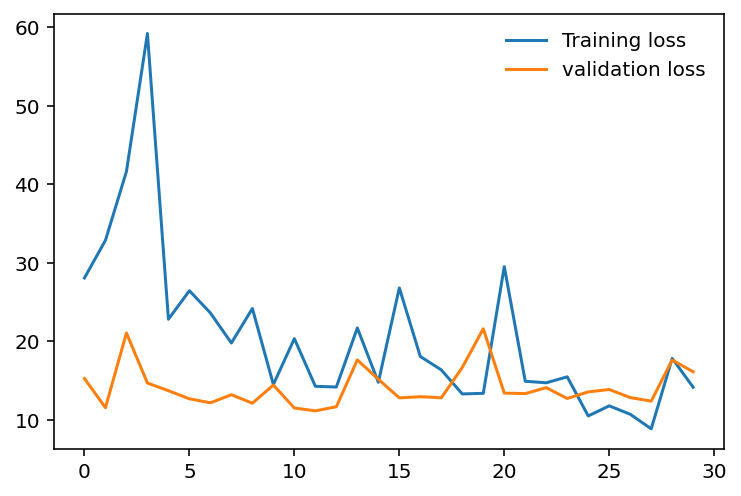

In [ ]:
Helper.check_overfitted(train_loss, test_loss)

In [ ]:
# track test loss
test_loss     = 0.0
class_correct = [0]*2
class_total   = [0]*2

model.eval()

# For generating confusion matrix
conf_matrix = np.zeros((2,2))

# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data   = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = gabornet(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(conf_matrix)

Test Loss: 0.111038

Test Accuracy of   0: 77% (225/290)
Test Accuracy of   1: 74% (228/308)

Test Accuracy (Overall): 75% (453/598)
[[225.  65.]
 [ 80. 228.]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[225.  65.]
 [ 80. 228.]]


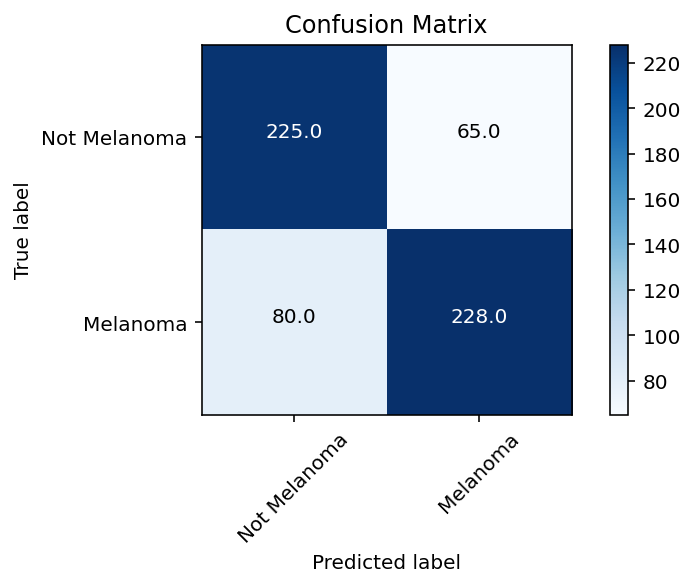

In [ ]:
import itertools  
cm_plot_labels = ['Not Melanoma','Melanoma']
plot_confusion_matrix(cm=conf_matrix, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score


# Shift

In [ ]:
class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.4488, 0.4371, 0.4040), rgb_std=(1.0, 1.0, 1.0), sign=-1):

        super(MeanShift, self).__init__(3, 9, kernel_size=(5,5))
        std = torch.Tensor(rgb_std)
        
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        for p in self.parameters():
            p.requires_grad = False

In [ ]:


class ShiftNN(nn.Module):
    def __init__(self):
        super(ShiftNN, self).__init__()
        self.s0 = MeanShift(3,9,(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(435600,10)

    def forward(self, x):
        x = nn.functional.relu(self.s0(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

shiftnet = ShiftNN().to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(shiftnet.parameters(), lr=0.003)
ShiftNN().to(device)

ShiftNN(
  (s0): MeanShift(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten()
  (fc): Linear(in_features=435600, out_features=10, bias=True)
)

In [ ]:
shiftnet, train_loss, test_loss = Helper.train(shiftnet, trainloader, testloader, 5, optimizer, criterion)

Epoch: 1/5
		Going for validation
	Train loss:nan.. 	Valid Loss:nan.. 	Accuracy: 48.4950
	Epoch:1 completed in 0m 13s
Epoch: 2/5
		Going for validation
	Train loss:nan.. 	Valid Loss:nan.. 	Accuracy: 48.4950
	Epoch:2 completed in 0m 13s
Epoch: 3/5
		Going for validation
	Train loss:nan.. 	Valid Loss:nan.. 	Accuracy: 48.4950
	Epoch:3 completed in 0m 13s
Epoch: 4/5
		Going for validation
	Train loss:nan.. 	Valid Loss:nan.. 	Accuracy: 48.4950
	Epoch:4 completed in 0m 13s
Epoch: 5/5
		Going for validation
	Train loss:nan.. 	Valid Loss:nan.. 	Accuracy: 48.4950
	Epoch:5 completed in 0m 13s
Training completed in 1m 7s


RuntimeError: ignored

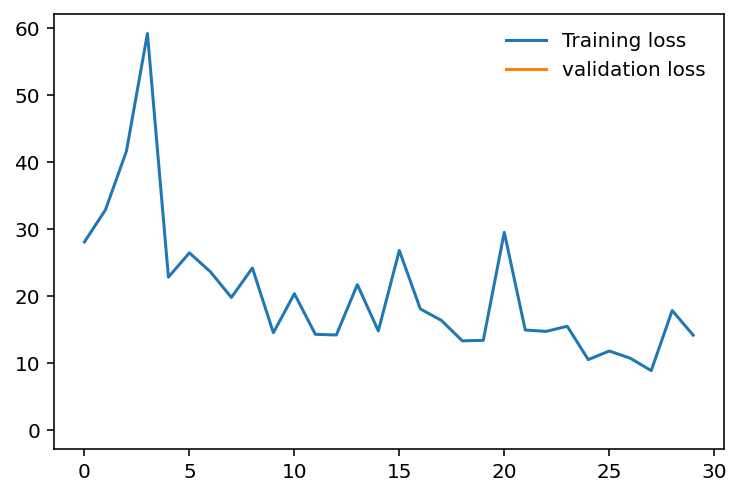

In [ ]:
Helper.check_overfitted(train_loss, test_loss)

In [ ]:
# track test loss
test_loss     = 0.0
class_correct = [0]*2
class_total   = [0]*2

model.eval()

# For generating confusion matrix
conf_matrix = np.zeros((2,2))

# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data   = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = shiftnet(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(conf_matrix)

Test Loss: nan

Test Accuracy of   0: 100% (290/290)
Test Accuracy of   1:  0% ( 0/308)

Test Accuracy (Overall): 48% (290/598)
[[290.   0.]
 [308.   0.]]


In [ ]:
def _get_conv_out(self, shape):
        output = self.conv(torch.zeros(1, *shape)) # not (32, *size)
        return int(numpy.prod(output.size()))

In [ ]:


class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.s0 = MeanShift(3,9,(5,5))
        self.g0 = GaborConv2d(in_channels=9,out_channels=64,kernel_size=(220,220))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(27878399,10)

    def forward(self, x):
        x = nn.functional.relu(self.s0(x))
        x = nn.functional.relu(self.g0(x))
        x = self.flatten(x)
        x=x.view(x.size(0),-1)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = NN().to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)
NN().to(device)

RuntimeError: ignored

In [ ]:
net, train_loss, test_loss = Helper.train(net, trainloader, testloader, 5, optimizer, criterion)